Age feature in the dataset has missing values. Build a decision tree model that uses other features to estimate age. You can use any features you want.

Use decision tree model to fill only the missing values.

# Setup

In [46]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from graphviz import Source
from sklearn.tree import export_graphviz

!pip install graphviz

# Get the data

In [47]:
train_age = pd.read_csv("train.csv", index_col='PassengerId') 
test_age = pd.read_csv("test.csv", index_col='PassengerId') 

Combie the datasets

In [4]:
titanic = pd.concat([train_age, test_age], sort=True)

Clean up datasets so no missing values

In [5]:
titanic.isnull().sum()

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Survived     418
Ticket         0
dtype: int64

# Preparing the Data

77% of 'cabin' values are missing...could I drop them for the dataset

In [6]:
titanic.drop('Cabin', axis=1, inplace=True)

Filling in the gaps for the rest of the data

In [7]:
titanic = titanic.fillna({"Embarked": "S"})
titanic['Fare'].fillna(titanic['Fare'].median(), inplace=True)
titanic['Survived'].fillna(titanic['Survived'].median(), inplace=True)

In [8]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Age         1046 non-null float64
Embarked    1309 non-null object
Fare        1309 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    1309 non-null float64
Ticket      1309 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 112.5+ KB


In [9]:
titanic["Fare"] = titanic["Fare"].astype(int)
titanic["Survived"] = titanic["Survived"].astype(int)

Drop varaibles that I am not using

In [10]:
titanic = train_age.drop(['Name','Embarked','Ticket','Cabin'], axis = 1)

In [11]:
sex_mapping = {"male": 0, "female": 1}

In [12]:
titanic['Sex'] = titanic['Sex'].map(sex_mapping)

Feature engeering to detemine family size: 'sibsp' + 'parch' + 1

In [13]:
titanic["Fam_size"] = titanic["SibSp"]+titanic["Parch"] +1

In [48]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fam_size
PassengerId,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,2
2,1,1,1,38.0,1,0,71.2833,2
3,1,3,1,26.0,0,0,7.9250,1
4,1,1,1,35.0,1,0,53.1000,2
5,0,3,0,35.0,0,0,8.0500,1


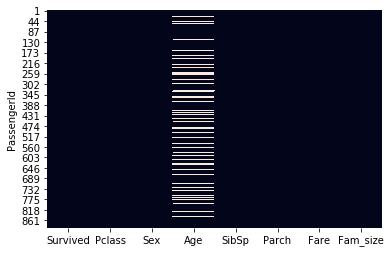

In [15]:
sns.heatmap(titanic.isnull(),cbar=False)

In [16]:
train = titanic[titanic.isnull().any(axis=1)]
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fam_size
PassengerId,,,,,,,,
6,0,3,0,NaN,0,0,8.4583,1
18,1,2,0,NaN,0,0,13.0000,1
20,1,3,1,NaN,0,0,7.2250,1
27,0,3,0,NaN,0,0,7.2250,1
29,1,3,1,NaN,0,0,7.8792,1


In [17]:
test = titanic.dropna()
test.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fam_size
PassengerId,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,2
2,1,1,1,38.0,1,0,71.2833,2
3,1,3,1,26.0,0,0,7.9250,1
4,1,1,1,35.0,1,0,53.1000,2
5,0,3,0,35.0,0,0,8.0500,1


In [18]:
test.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Fam_size    0
dtype: int64

In [19]:
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Fam_size      0
dtype: int64

# Explore the data

pclass = Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

survival = Survival	0 = No, 1 = Yes

sibsp =	# of siblings / spouses aboard the Titanic	

parch =	# of parents / children aboard the Titanic

embarked =	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [20]:
titanic.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fam_size
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,1.904602
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,1.613459
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,11.000000


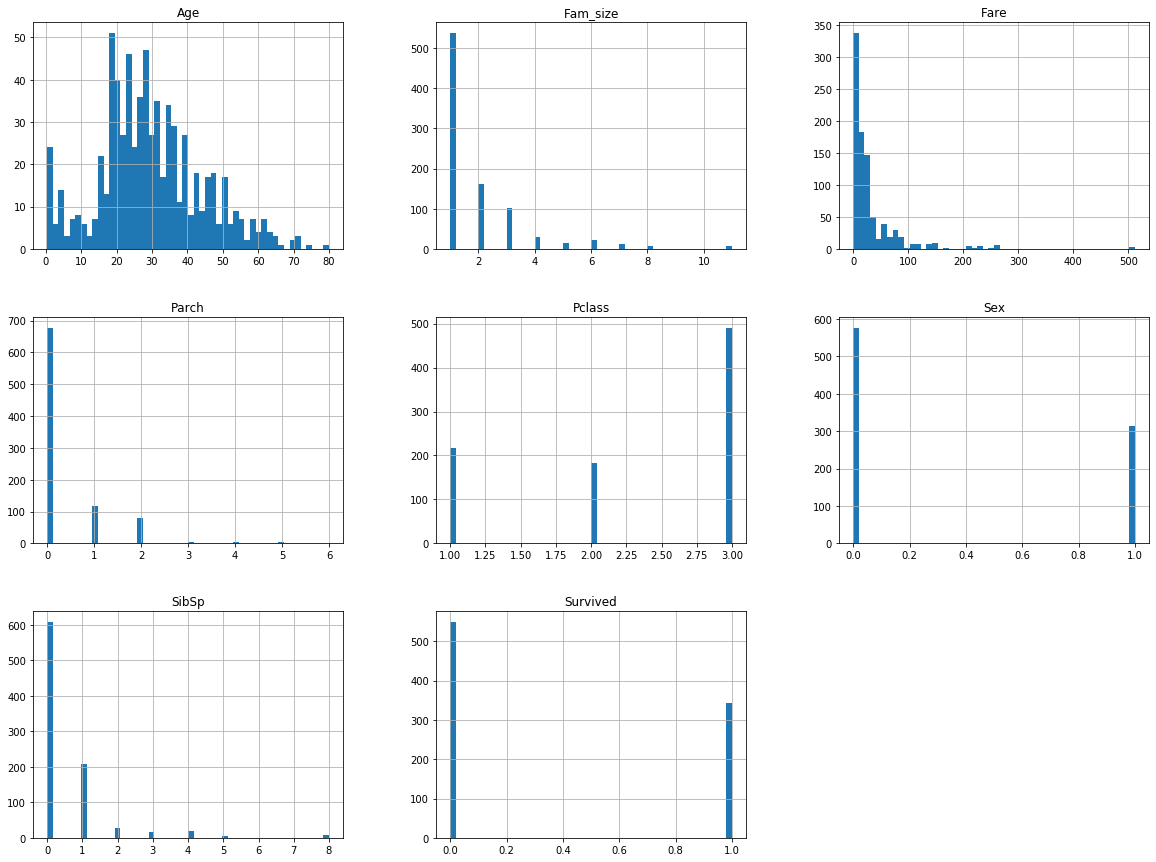

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
titanic.hist(bins=50, figsize=(20,15))
plt.show()

For Age, there is moderate correlation for Fam_size, SibSp, and Pclass.

In [22]:
corr_matrix = titanic.corr()
corr_matrix["Age"].sort_values(ascending=False)

Age         1.000000
Fare        0.096067
Survived   -0.077221
Sex        -0.093254
Parch      -0.189119
Fam_size   -0.301914
SibSp      -0.308247
Pclass     -0.369226
Name: Age, dtype: float64

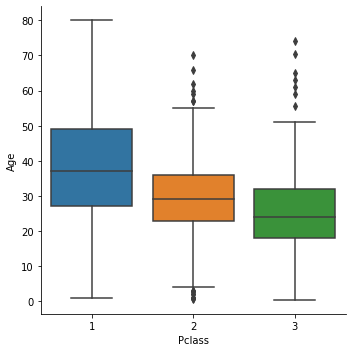

In [23]:
sns.catplot(x='Pclass', y='Age', data=titanic, kind='box')

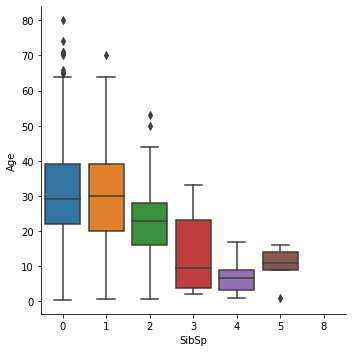

In [24]:
sns.catplot(x='SibSp', y='Age', data=titanic, kind='box')

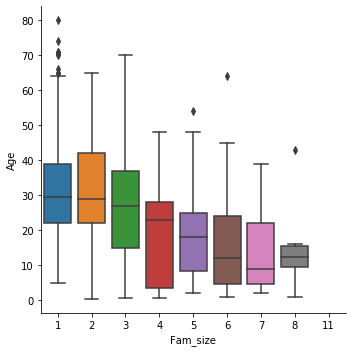

In [25]:
sns.catplot(x='Fam_size', y='Age', data=titanic, kind='box')

Thought this graph looked cool.
Peaks for pclass (Ticket class) by their age

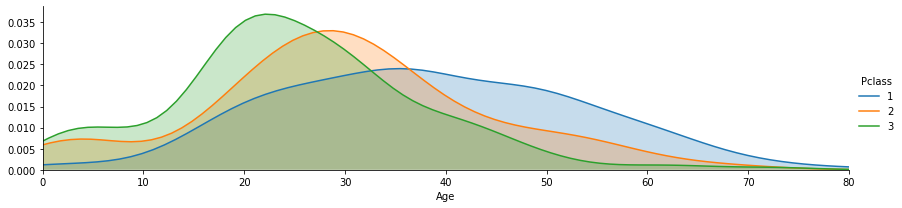

In [26]:
facet = sns.FacetGrid(titanic, hue="Pclass",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic['Age'].max()))
facet.add_legend()

# Preparing the examples and training the ML algorithm

In [27]:
X = train.drop('Age', axis = 1)
y = train['Age']

In [28]:
X

,Survived,Pclass,Sex,SibSp,Parch,Fare,Fam_size
PassengerId,,,,,,,
6,0,3,0,0,0,8.4583,1
18,1,2,0,0,0,13.0000,1
20,1,3,1,0,0,7.2250,1
27,0,3,0,0,0,7.2250,1
29,1,3,1,0,0,7.8792,1
...,...,...,...,...,...,...,...
860,0,3,0,0,0,7.2292,1
864,0,3,1,8,2,69.5500,11
869,0,3,0,0,0,9.5000,1


In [29]:
y

PassengerId
6     NaN
18    NaN
20    NaN
27    NaN
29    NaN
       ..
860   NaN
864   NaN
869   NaN
879   NaN
889   NaN
Name: Age, Length: 177, dtype: float64

In [30]:
!pip install graphviz

In [31]:
import os

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
dtree = DecisionTreeClassifier(random_state = 42)

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 774 to 503
Data columns (total 7 columns):
Survived    141 non-null int64
Pclass      141 non-null int64
Sex         141 non-null int64
SibSp       141 non-null int64
Parch       141 non-null int64
Fare        141 non-null float64
Fam_size    141 non-null int64
dtypes: float64(1), int64(6)
memory usage: 8.8 KB


In [37]:
y_train

PassengerId
774   NaN
651   NaN
486   NaN
779   NaN
187   NaN
       ..
360   NaN
523   NaN
56    NaN
465   NaN
503   NaN
Name: Age, Length: 141, dtype: float64

In [38]:
from sklearn import preprocessing
from sklearn import utils

To fix
ValueError: Unknown label type: 'continuous'

In [39]:
lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(y_train)

In [40]:
dtree.fit(X_train, training_scores_encoded)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [41]:
predictions = dtree.predict(X_test)
predictions

array([ 16, 140,   8,  44, 110,  79,  16,  28,  57, 125, 110,  28,  55,
        57,  88, 100,   1, 103,   1,  93,   7,   1,  52,   7,  55,   1,
       103,  74, 125, 120,  68,  33, 114,  55,  16,  24])

In [42]:
y_train

PassengerId
774   NaN
651   NaN
486   NaN
779   NaN
187   NaN
       ..
360   NaN
523   NaN
56    NaN
465   NaN
503   NaN
Name: Age, Length: 141, dtype: float64

In [43]:
len(train)

177

In [44]:
len(test)

714

In [45]:
results = pd.DataFrame({
    'actual': y_test,
    'prediction': predictions
})
results

,actual,prediction
PassengerId,,
83,NaN,16
236,NaN,140
668,NaN,8
159,NaN,44
348,NaN,110
66,NaN,79
574,NaN,16
864,NaN,28
532,NaN,57
